In [1]:
import os
import cv2 
import wget
import numpy as np
import object_detection
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from object_detection.utils import label_map_util, visualization_utils, config_util
from object_detection.builders import model_builder

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [2]:
# Define data paths 
DATA_PATHS = {
    "pipeline_config": "model_checkpoints/pipeline.config", 
    "checkpoints_dir": "model_checkpoints/",
    "label_map_path": "tf_downloads/tf_annotations/label_map.pbtxt", 
    "inference": "inference/", 
    "cnn_filter_model": "model_checkpoints/cnn_filter.h5"
}

In [3]:
configs = config_util.get_configs_from_pipeline_file(DATA_PATHS['pipeline_config'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(DATA_PATHS['checkpoints_dir'], 'ckpt-37')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

category_index = label_map_util.create_category_index_from_labelmap(DATA_PATHS['label_map_path'])

In [4]:
%matplotlib inline

1/1 [==============================] - 0s 47ms/step
Damaged
Smash


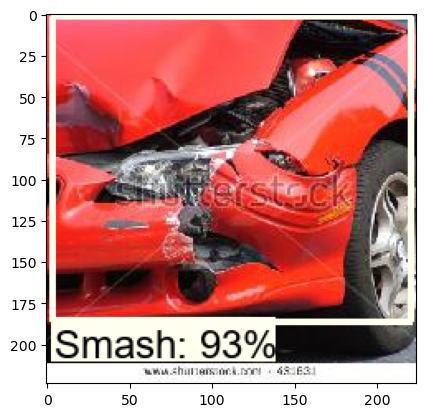

1/1 [==============================] - 0s 20ms/step
Damaged
Smash


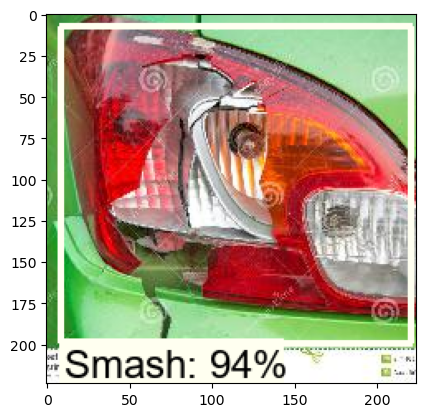

1/1 [==============================] - 0s 19ms/step
Damaged
Glass shattered


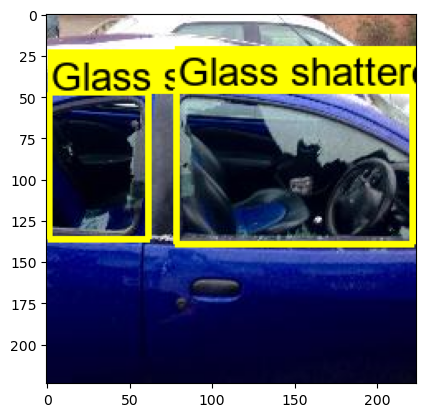

1/1 [==============================] - 0s 30ms/step
Damaged
Scratch


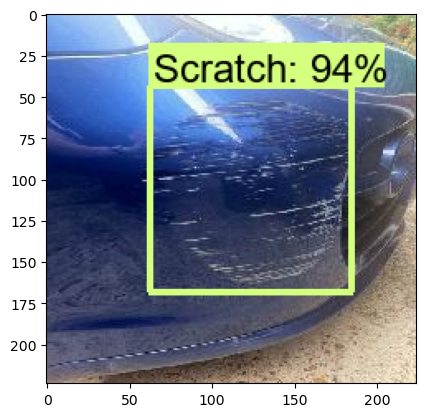

1/1 [==============================] - 0s 28ms/step
Damaged
Dent


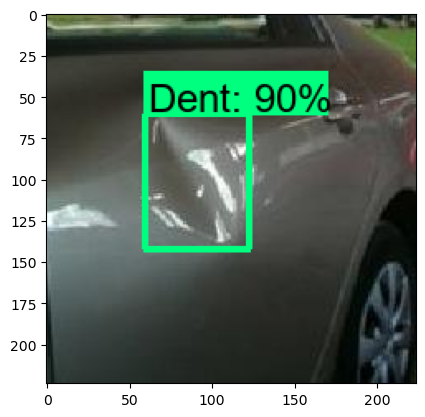

1/1 [==============================] - 0s 14ms/step
Damaged
Scratch


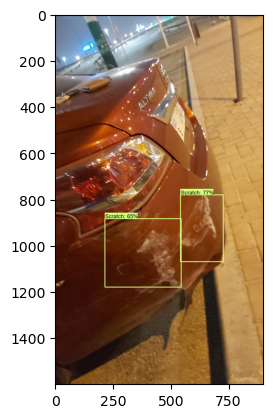

1/1 [==============================] - 0s 33ms/step
Damaged
Scratch


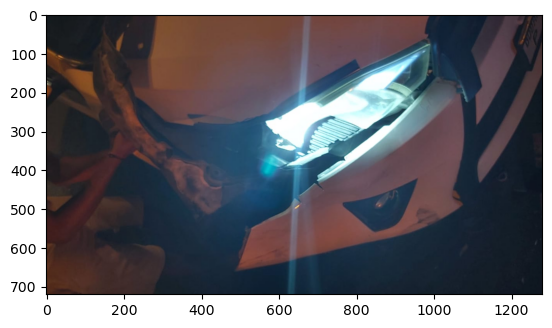

1/1 [==============================] - 0s 21ms/step
Clear
1/1 [==============================] - 0s 21ms/step
Damaged
Scratch


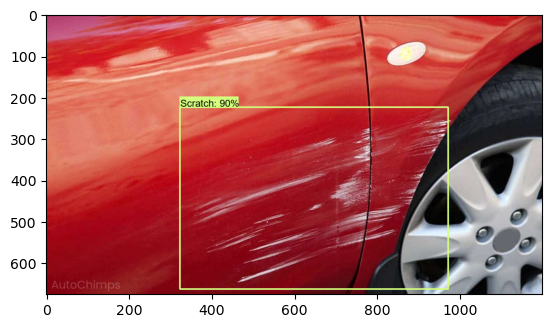

In [6]:
model = load_model(DATA_PATHS["cnn_filter_model"])

for i in os.listdir(DATA_PATHS["inference"]):
    IMAGE_PATH = os.path.join(DATA_PATHS["inference"], i)
    
    # Resizing image to suit modelled parameters
    img = image.load_img(IMAGE_PATH, target_size = (64, 64))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)

    # Prediction
    pred = model.predict(x)

    # Mapping prediction to the label 
    isDamage = ['Clear', 'Damaged']
    prediction = isDamage[np.argmax(pred)]
    print(prediction)
    
    if prediction == 'Damaged':
        img = cv2.imread(IMAGE_PATH)
        image_np = np.array(img)

        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)

        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
        detections['num_detections'] = num_detections
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        index = detections['detection_classes'][0] + 1 
        print(category_index[index]['name'])

        visualization_utils.visualize_boxes_and_labels_on_image_array(
                    image_np_with_detections,
                    detections['detection_boxes'],
                    detections['detection_classes']+label_id_offset,
                    detections['detection_scores'],
                    category_index,
                    use_normalized_coordinates=True,
                    max_boxes_to_draw=5,
                    min_score_thresh=.4,
                    agnostic_mode=False
        )

        plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
        plt.show()

In [ ]:
cap = cv2.VideoCapture("detect.mp4")

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    visualization_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=1,
                min_score_thresh=.5,
                agnostic_mode=False)

    cv2.imshow('Car Damage Detection_Jaison_Sania',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break